The following code is based on the article "A Mathematical Model of Skeletal Muscle Disease and Immune Response in the mdx Mouse", written by Jarrah et al. and published in 2014. The values chosen for the parameters are the ones estimated in the paper. The trajectories follow a similar pattern as the ones in the paper, but they are not exactly the same. This is probably due to a mistake in my code; so far, however, I've not been able to find it.

In [3]:
def DMD_model(t, state_variables, initial_conditions, parameters):

    H, C, M, N, D, R = state_variables
    H_i, C_i, M_i, N_i, D_i, R_i = initial_conditions
    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D = parameters
       # [0.0324139, 0.115375, 0.766576, 0.123848, 4.09948e-3, 3.23097e-4, 0.83355, 1.61511, 0.781155, 1.34671]
    
    dHdt=ev_H(H, M, D, H_i, k1, d_H)
    dCdt=ev_C(H, C, D, C_i, k2, d_C)
    dMdt=ev_M(M, D, M_i, k3, d_M)
    dNdt=ev_N(t, C, N, R, R_i, k4, k5)
    dDdt=ev_D(t, C, M, N, D, D_i, k5, k6, d_D)
    dRdt=ev_R(M, D, R, R_i, k4, k6, d_D)

    return [dHdt, dCdt, dMdt, dNdt, dDdt, dRdt]

######################################### damage as a function of time ###################################################
def damage(t):

    sigma, m, h = 2.92815, 4.22686, 0.511657

    if t==0 or t <=1e-10:       ######## Elena, ricontrollati i limiti dei float
        return 0.

    else:
        #print(t, end="   ")
        #print(h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2)))
        return h / (t * sigma * np.sqrt(2*np.pi)) * np.exp(-(np.log(t) - m)**2 / (2. * sigma**2))


########################################## differential equations ######################################################
def ev_H(H, M, D, H_i, k1, d_H):

    b_H = d_H * H_i           #Turnover rate of CD4+ T cells
    
    return b_H + k1 * M * D - d_H * H

def ev_C(H, C, D, C_i, k2, d_C):

    b_C = d_C * C_i          #Turnover rate of CD8+ T cells
    
    return b_C + k2 * H * D - d_C * C
    
def ev_M(M, D, M_i, k3, d_M):

    b_M = d_M * M_i          #Turnover rate of macrophages

    return b_M + k3 * M * D - d_M * M

def ev_N(t, C, N, R, R_i, k4, k5):

    return k4 * R - k5 * C * N - damage(t) * N

def ev_D(t, C, M, N, D, D_i, k5, k6, d_D):

    return k5 * C * N + damage(t) * N - k6 * D * M - d_D * D

def ev_R( M, D, R, R_i, k4, k6, d_D):

    return k6 * D * M + d_D * D - k4 * R   

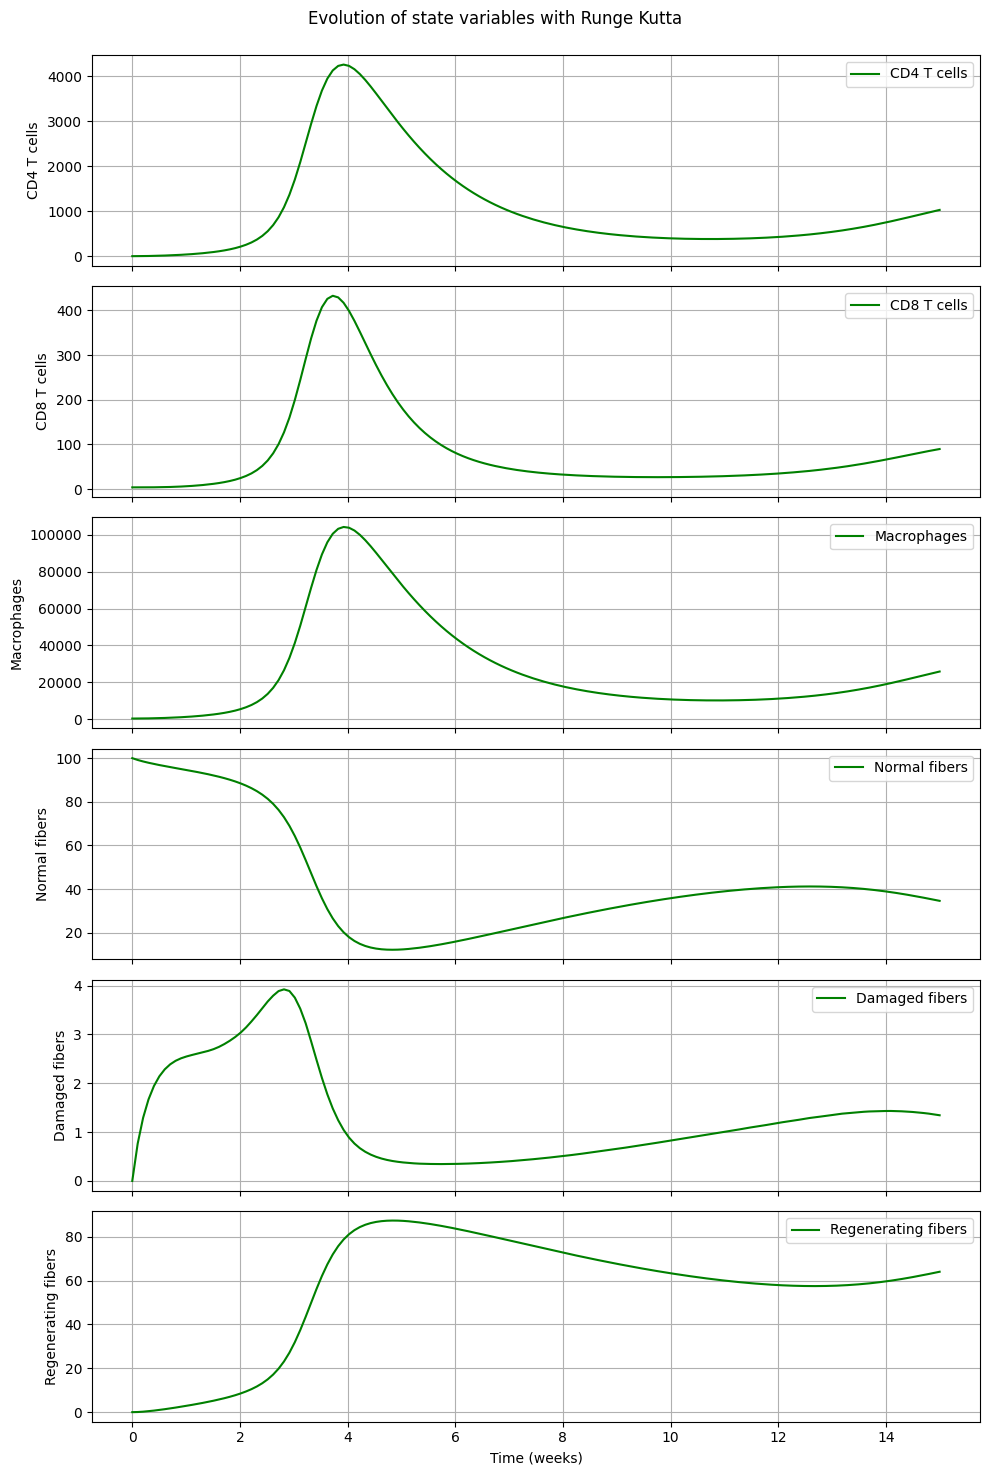

In [5]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from functools import partial 

initial_conditions = [0., 4., 400., 100., 0., 0.]
t_span = (0, 15)
t_eval = np.linspace(0, 15, 150)

#parameters from Jarrah's article
parameters = [0.0324139, 0.115375, 0.766576, 0.123848, 4.09948e-3, 3.23097e-4, 0.83355, 1.61511, 0.781155, 1.34671]

#use partial function to include initial conditions
DMD_model_ic = partial(DMD_model, initial_conditions = initial_conditions, parameters=parameters)

#solve with Runge Kutta 4
solution = solve_ivp(DMD_model_ic, t_span, initial_conditions, method='RK45', t_eval=t_eval)

#extract values
t_values = solution.t
values = solution.y

n_vars = values.shape[0]
labels = ["CD4 T cells", "CD8 T cells", "Macrophages", "Normal fibers", "Damaged fibers", "Regenerating fibers"]

#create subplots
fig, axes = plt.subplots(n_vars, 1, figsize=(10, 15), sharex=True)

#plot each state variable in a separate subplot
for i in range(n_vars):
    axes[i].plot(t_values, values[i], label=labels[i], color='green')
    axes[i].set_ylabel(labels[i])
    axes[i].legend()
    axes[i].grid(True)

#the last subplot is the only one with the label on the x axes
axes[-1].set_xlabel('Time (weeks)')


#title
fig.suptitle('Evolution of state variables with Runge Kutta')


#adjust layout to prevent overlap
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig(f"RK4.png")

plt.show()